In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as cn
from astropy import units as u
from scipy.integrate import quad
from scipy.interpolate import interp1d
%matplotlib inline

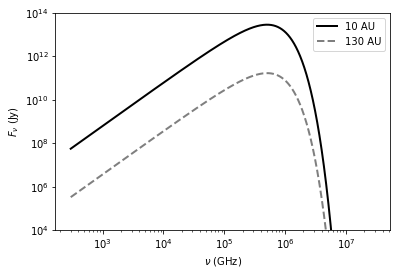

In [3]:
#Part 1

#Define some constants
h = cn.h.to('erg s').value
c = cn.c.to('cm s-1').value
kb = cn.k_B.to('erg K-1').value
nu = np.linspace(3.0e11, 3.0e16, 50000) #infrared to UV

def stellarBB(R_s, T_s, a):
    BB_num = 2 * np.pi * h * nu**3 / c**2
    BB_denom = np.exp((h*nu)/(kb*T_s)) - 1
    BB = BB_num / BB_denom #erg cm-2 s-1 Hz-1
    fnu = BB * (R_s/a)**2 * 1.0e23 #jansky
    return fnu
    
fomalhaut_close = stellarBB(1.842 * cn.R_sun.to('AU').value, 8590., (10 * u.AU).value)
fomalhaut_far = stellarBB(1.842 * cn.R_sun.to('AU').value, 8590., (130 * u.AU).value)
plt.loglog(nu/1.0e9, fomalhaut_close, 'k-', linewidth=2, label='10 AU')
plt.loglog(nu/1.0e9, fomalhaut_far, 'k--', linewidth=2, alpha=0.5, label='130 AU')
plt.ylim(1e4, 1e14)
plt.xlabel(r"$\nu$ (GHz)")
plt.ylabel(r"$F_{\nu}$ (Jy)")
plt.legend()
plt.savefig("381_hw3q1.jpg")
    

In [4]:
#Part 2

def power_in(R_s, T_s, a, R_g):
    if R_g == 0.1:
        wave, Qabs = np.genfromtxt('01micron.txt').T[0:2]
    elif R_g == 1.0:
        wave, Qabs = np.genfromtxt('1micron.txt').T[0:2]
    elif R_g == 10.0:
        wave, Qabs = np.genfromtxt('10micron.txt').T[0:2]
    elif R_g == 1000:
        wave = np.genfromtxt('10micron.txt').T[0]
        Qabs = np.linspace(1, 1, len(wave))
        
    nu_dust = cn.c.to('micron s-1').value / wave
    coeff = (R_g * R_s)**2 / (a**2)
    
    #interpolate the Q_abs terms
    y = interp1d(nu_dust, Qabs)
    Qabs_new = y(nu)
    
    def integrand(nu):
        BB_num = 2 * np.pi * h * nu**3 / c**2
        BB_denom = np.exp((h*nu)/(kb*T_s)) - 1
        BB = BB_num / BB_denom
        return BB
    
    power = []
    for n in range(0, len(nu)-1):
        integral = np.trapz(integrand(nu[n:-1])*Qabs_new[n], nu[n:-1])
        power.append(integral)
        
    power = np.asarray(power)
    return coeff * power

fhclose_01 = power_in(1.842 * cn.R_sun.to('cm').value, 8590., (10 * u.AU).to('micron').value, 0.1)
fhclose_1 = power_in(1.842 * cn.R_sun.to('cm').value, 8590., (10 * u.AU).to('micron').value, 1.0)
fhclose_10 = power_in(1.842 * cn.R_sun.to('cm').value, 8590., (10 * u.AU).to('micron').value, 10.0)
fhclose_perf = power_in(1.842 * cn.R_sun.to('cm').value, 8590., (10 * u.AU).to('micron').value, 1000)

fhfar_01 = power_in(1.842 * cn.R_sun.to('cm').value, 8590., (130 * u.AU).to('micron').value, 0.1)
fhfar_1 = power_in(1.842 * cn.R_sun.to('cm').value, 8590., (130 * u.AU).to('micron').value, 1.0)
fhfar_10 = power_in(1.842 * cn.R_sun.to('cm').value, 8590., (130 * u.AU).to('micron').value, 10.0)
fhfar_perf = power_in(1.842 * cn.R_sun.to('cm').value, 8590., (130 * u.AU).to('micron').value, 1000)



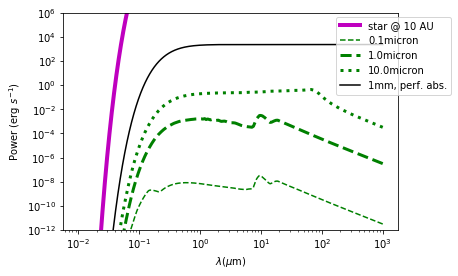

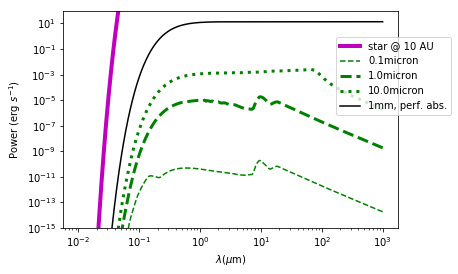

In [10]:
wave = cn.c.to('micron s-1').value / nu

plt.loglog(wave, fomalhaut_close, 'm-', linewidth=4, label='star @ 10 AU')
plt.loglog(wave[:-1], fhclose_01, 'g--', label='0.1micron')
plt.loglog(wave[:-1], fhclose_1, 'g--', linewidth=3, label='1.0micron')
plt.loglog(wave[:-1], fhclose_10, 'g:', linewidth=3, label='10.0micron')
plt.loglog(wave[:-1], fhclose_perf, 'k-', label='1mm, perf. abs.')
plt.ylim(1.0e-12, 1.0e6)
#plt.xlim(10**11.5, 10**16)
plt.xlabel("$\lambda (\mu$m)")
plt.ylabel("Power (erg $s^{-1}$)")
plt.legend(bbox_to_anchor=(0.8, 0.6))
plt.savefig('381_hw3q2a.jpg')
plt.show()

plt.loglog(wave, fomalhaut_close, 'm-', linewidth=4, label='star @ 10 AU')
plt.loglog(wave[:-1], fhfar_01, 'g--', label='0.1micron')
plt.loglog(wave[:-1], fhfar_1, 'g--', linewidth=3, label='1.0micron')
plt.loglog(wave[:-1], fhfar_10, 'g:', linewidth=3, label='10.0micron')
plt.loglog(wave[:-1], fhfar_perf, 'k-', label='1mm, perf. abs.')
plt.ylim(1.0e-15, 1.0e2)
#plt.xlim(10**11.5, 10**16)
plt.xlabel("$\lambda (\mu$m)")
plt.ylabel("Power (erg $s^{-1}$)")
plt.legend(bbox_to_anchor=(0.8, 0.9))
plt.savefig('381_hw3q2b.jpg')
plt.show()

In [11]:
#Part 3

def power_out(T_s, a, R_g, R_s):
    #First find equilibrium temperature; simplifying the equation, we find a simple relationship w/ R_s & T_s
    T_g = np.sqrt(2*R_s/a) * T_s
    
    if R_g == 0.1:
        wave, Qabs = np.genfromtxt('01micron.txt').T[0:2]
    elif R_g == 1.0:
        wave, Qabs = np.genfromtxt('1micron.txt').T[0:2]
    elif R_g == 10.0:
        wave, Qabs = np.genfromtxt('10micron.txt').T[0:2]
    elif R_g == 1000:
        wave = np.genfromtxt('10micron.txt').T[0]
        Qabs = np.linspace(1, 1, len(wave))
        
    nu_dust = cn.c.to('micron s-1').value / wave
    coeff = 4 * np.pi * ((R_g * u.micron).to('cm'))**2
    
    #interpolate the Q_abs terms
    y = interp1d(nu_dust, Qabs)
    Qabs_new = y(nu)
    
    def integrand(nu): #this time it's the blackbody of the dust
        BB_num = 2 * np.pi * h * nu**3 / c**2
        BB_denom = np.exp((h*nu)/(kb*T_g)) - 1
        BB = BB_num / BB_denom
        return BB
    
    power = []
    for n in range(0, len(nu)-1):
        integral = np.trapz(integrand(nu[n:-1])*Qabs_new[n], nu[n:-1])
        power.append(integral)
        
    power = np.asarray(power)
    return coeff * power

fhclose_01 = power_out(8590., (10 * u.AU).to('micron').value, 0.1, 1.842 * cn.R_sun.to('micron').value)
fhclose_1 = power_out(8590., (10 * u.AU).to('micron').value, 1.0, 1.842 * cn.R_sun.to('micron').value)
fhclose_10 = power_out(8590., (10 * u.AU).to('micron').value, 10.0, 1.842 * cn.R_sun.to('micron').value)
fhclose_perf = power_out(8590., (10 * u.AU).to('micron').value, 1000, 1.842 * cn.R_sun.to('micron').value)

fhfar_01 = power_out(8590., (130 * u.AU).to('micron').value, 0.1, 1.842 * cn.R_sun.to('micron').value)
fhfar_1 = power_out(8590., (130 * u.AU).to('micron').value, 1.0, 1.842 * cn.R_sun.to('micron').value)
fhfar_10 = power_out(8590., (130 * u.AU).to('micron').value, 10.0, 1.842 * cn.R_sun.to('micron').value)
fhfar_perf = power_out(8590., (130 * u.AU).to('micron').value, 1000, 1.842 * cn.R_sun.to('micron').value)

    

/Users/jackiebradli/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


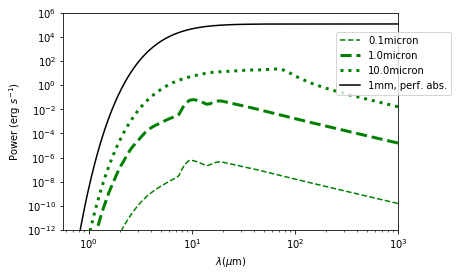

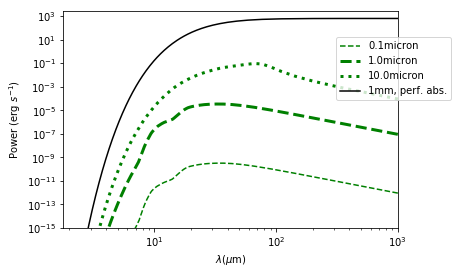

In [12]:
wave = cn.c.to('micron s-1').value / nu


plt.loglog(wave[:-1], fhclose_01, 'g--', label='0.1micron')
plt.loglog(wave[:-1], fhclose_1, 'g--', linewidth=3, label='1.0micron')
plt.loglog(wave[:-1], fhclose_10, 'g:', linewidth=3, label='10.0micron')
plt.loglog(wave[:-1], fhclose_perf, 'k-', label='1mm, perf. abs.')
plt.ylim(1.0e-12, 1.0e6)
plt.xlim(10**(-0.25), 1e3)
plt.xlabel("$\lambda (\mu$m)")
plt.ylabel("Power (erg $s^{-1}$)")
plt.legend(bbox_to_anchor=(0.8, 0.6))
plt.savefig('381_hw3q3a.jpg')
plt.show()

plt.loglog(wave[:-1], fhfar_01, 'g--', label='0.1micron')
plt.loglog(wave[:-1], fhfar_1, 'g--', linewidth=3, label='1.0micron')
plt.loglog(wave[:-1], fhfar_10, 'g:', linewidth=3, label='10.0micron')
plt.loglog(wave[:-1], fhfar_perf, 'k-', label='1mm, perf. abs.')
plt.ylim(1.0e-15, 10**3.5)
plt.xlim(10**(0.25), 1e3)
plt.xlabel("$\lambda (\mu$m)")
plt.ylabel("Power (erg $s^{-1}$)")
plt.legend(bbox_to_anchor=(0.8, 0.9))
plt.savefig('381_hw3q3b.jpg')
plt.show()

/Users/jackiebradli/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


1.08345742182e+15


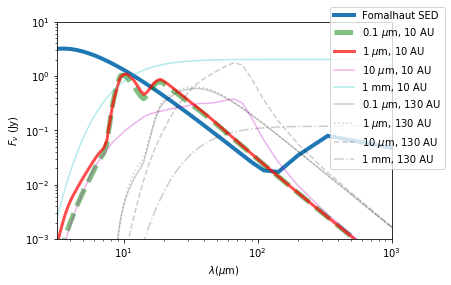

In [17]:
#Part 4

SEDs = np.array([fhclose_01, fhclose_1, fhclose_10, fhclose_perf, fhfar_01, fhfar_1, fhfar_10, fhfar_perf])\
/ ((7.7 * u.pc).to('cm').value)**2
                                            
#artificially place it 7 pc away from us 

nu = np.linspace(3.0e11, 3.0e16, 50000)

def BB(T):
    BB_num = 2 * np.pi * h * nu**3 / c**2
    BB_denom = np.exp((h*nu)/(kb*T)) - 1
    BB = BB_num / BB_denom #erg cm-2 s-1 Hz-1
    return BB * 1.0e23 #turn it into flux density

plt.loglog(wave, (BB(1449)/5.69e16+BB(11.592)/1.08e12), linewidth=4, label='Fomalhaut SED')
plt.loglog(wave[:-1], SEDs[0] * 1e45, 'g--', linewidth=5, alpha=0.5, label=r'0.1 $\mu$m, 10 AU')
plt.loglog(wave[:-1], SEDs[1] * 1e40, 'r-', linewidth=3, alpha=0.7,  label=r'1 $\mu$m, 10 AU')
plt.loglog(wave[:-1], SEDs[2] * 1e37, 'm-', alpha=0.3, label=r'10 $\mu$m, 10 AU')
plt.loglog(wave[:-1], SEDs[3] * 1e34, 'c-', alpha=0.3, label=r'1 mm, 10 AU')

plt.loglog(wave[:-1], SEDs[4] * 1.0e48, 'k-', alpha=0.2, label=r'0.1 $\mu$m, 130 AU')
plt.loglog(wave[:-1], SEDs[5] * 1.0e43, 'k:', alpha=0.2, label=r'1 $\mu$m, 130 AU')
plt.loglog(wave[:-1], SEDs[6] * 1.0e40, 'k--', alpha=0.2, label=r'10 $\mu$m, 130 AU')
plt.loglog(wave[:-1], SEDs[7] * 1.0e35, 'k-.', alpha=0.2, label=r'1 mm, 130 AU')

plt.ylim(1e-3, 1e1)
plt.xlim(10**0.5, 1e3)
plt.legend(bbox_to_anchor=(0.8, 0.3))
print(max(BB(263)))

#dust mass

10**40 * (4/3) * np.pi * (10**3) / (1e45)

plt.xlabel('$\lambda (\mu$m)')
plt.ylabel(r"$F_{\nu}$ (Jy)")
plt.savefig('381_hw5q4.jpg')

In [18]:
#Part 5

#radiation pressure:
def radPR(T_s, a, R_g, R_s):
    R_g = 1.0e-4 * R_g #convert to cm
    L = 4 * np.pi * R_s**2 * cn.sigma_sb.to('erg cm-2 s-1 K-4').value * T_s**4
    Q = 1.5 #assume somewhere in between an absorber and a reflector
    P_in = 0.25 * L * (R_g / a)**2 * Q
    F_rad = P_in / cn.c.to('cm s-1').value
    P_rad = F_rad / (4 * np.pi * R_g**2)
    density = 2 #g cm-3
    M_g = density * (4/3) * np.pi * (R_g)**3 #volume of a dust grain
    PoyRob = F_rad * np.sqrt(cn.G.to('cm3 g-1 s-2').value * M_g / a) / cn.c.to('cm s-1').value
    return P_rad, PoyRob

fhclose_01 = radPR(8590., (10 * u.AU).to('cm').value, 0.1, 1.842 * cn.R_sun.to('cm').value)
fhclose_1 = radPR(8590., (10 * u.AU).to('cm').value, 1.0, 1.842 * cn.R_sun.to('cm').value)
fhclose_10 = radPR(8590., (10 * u.AU).to('cm').value, 10.0, 1.842 * cn.R_sun.to('cm').value)
fhclose_perf = radPR(8590., (10 * u.AU).to('cm').value, 1000, 1.842 * cn.R_sun.to('cm').value)

fhfar_01 = radPR(8590., (130 * u.AU).to('cm').value, 0.1, 1.842 * cn.R_sun.to('cm').value)
fhfar_1 = radPR(8590., (130 * u.AU).to('cm').value, 1.0, 1.842 * cn.R_sun.to('cm').value)
fhfar_10 = radPR(8590., (130 * u.AU).to('cm').value, 10.0, 1.842 * cn.R_sun.to('cm').value)
fhfar_perf = radPR(8590., (130 * u.AU).to('cm').value, 1000, 1.842 * cn.R_sun.to('cm').value)

print(fhclose_01)

(2.8322235866714866e-06, 2.2950977547145159e-43)


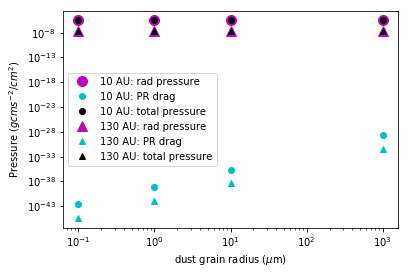

In [19]:
dust_radii = np.asarray([0.1, 1, 10, 1000])

plt.loglog(dust_radii, np.array([fhclose_01[0], fhclose_1[0], fhclose_10[0], fhclose_perf[0]]), 'om',\
           label='10 AU: rad pressure', markersize=10)
plt.loglog(dust_radii, np.array([fhclose_01[1], fhclose_1[1], fhclose_10[1], fhclose_perf[1]]), 'oc',\
           label='10 AU: PR drag')
plt.loglog(dust_radii, np.array([fhclose_01[0]+fhclose_01[1], fhclose_1[0]+fhclose_1[1],\
                               fhclose_10[0]+fhclose_10[1], fhclose_perf[0]+fhclose_perf[1]]), 'ok',\
           label='10 AU: total pressure')

plt.loglog(dust_radii, np.array([fhfar_01[0], fhfar_1[0], fhfar_10[0], fhfar_perf[0]]), '^m',\
           label='130 AU: rad pressure', markersize=10)
plt.loglog(dust_radii, np.array([fhfar_01[1], fhfar_1[1], fhfar_10[1], fhfar_perf[1]]), '^c',\
           label='130 AU: PR drag')
plt.loglog(dust_radii, np.array([fhfar_01[0]+fhfar_01[1], fhfar_1[0]+fhfar_1[1],\
                               fhfar_10[0]+fhfar_10[1], fhfar_perf[0]+fhfar_perf[1]]), '^k',\
           label='130 AU: total pressure')

plt.legend()

plt.ylabel("Pressure ($g cm s^{-2} / cm^{2}$)")
plt.xlabel("dust grain radius ($\mu$m)")

plt.savefig('381_hw3q5.jpg')
